In [69]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

import os
import copy

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Ellipse

import umap

import einops
import pandas as pd, itertools
from tqdm.auto import tqdm

from transformer_lens import HookedTransformer, HookedTransformerConfig, utils

from data import get_dataset

# Configure plotly to use static rendering if widgets fail
import plotly.io as pio
pio.renderers.default = "notebook"

float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Data and Model setup

In [70]:
# ---------- parameters ----------
LIST_LEN = 2 # [d1, d2]
SEQ_LEN = LIST_LEN * 2 + 1 # [d1, d2, SEP, o1, o2]

N_DIGITS = 100
DIGITS = list(range(N_DIGITS)) # 100 digits from 0 to 99
PAD = N_DIGITS # special padding token
SEP = N_DIGITS + 1 # special seperator token for the model to think about the input (+1 to avoid confusion with the last digit)
VOCAB = len(DIGITS) + 2  # + the special tokens

D_MODEL = 128
N_HEAD = 1
N_LAYER = 2
USE_LN = False # use layer norm in model
USE_BIAS = False # use bias in model
FREEZE_WV = True # no value matrix in attn 
FREEZE_WO = True # no output matrix in attn (i.e. attn head can only copy inputs to outputs)

LEARNING_RATE = 1e-3 # default 1e-3
WEIGHT_DECAY = 0.01 # default 0.01
MAX_TRAIN_STEPS = 50_000 # max training steps
USE_CHECKPOINTING = False # whether to use checkpointing for training

MODEL_NAME = f'{N_LAYER}layer_{N_DIGITS}dig_{D_MODEL}d'
MODEL_PATH = "models/" + MODEL_NAME + ".pt"

DEV = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
torch.manual_seed(0)

In [71]:
# ---------- mask ----------
# attention mask for [d1, d2, SEP, o1, o2] looks like this (query rows are horizontal, key columns are vertical):
# -    d1    d2    SEP    o1    o2   (keys)
# d1  -inf  -inf   -inf  -inf  -inf
# d2   0    -inf   -inf  -inf  -inf
# SEP  0      0    -inf  -inf  -inf
# o1  -inf  -inf    0    -inf   -inf
# o2  -inf  -inf    0      0    -inf
# (queries)

mask_bias = torch.triu(torch.ones(SEQ_LEN, SEQ_LEN) * float("-inf")) # upper triangular bias mask (lead_diag & above = -inf, rest = 0)
mask_bias[0, 0] = 0. # don't want a full row of -inf! otherwise we get nan erros & training breaks
mask_bias[LIST_LEN+1:, :LIST_LEN] = float("-inf") # stop output tokens from attending to input tokens
mask_bias = mask_bias.unsqueeze(0).unsqueeze(0) # (1,1,T,T) broadcastable across batch and heads

In [72]:
# ---------- dataset ----------
train_ds, val_ds = get_dataset(
    list_len=LIST_LEN, 
    n_digits=N_DIGITS, 
    train_split=0.8,
    mask_tok=PAD, # use PAD as mask token
    sep_tok=SEP, # use SEP as separator token
    )

train_batch_size = min(128, len(train_ds))
val_batch_size = min(256, len(val_ds))
train_dl = DataLoader(train_ds, train_batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, val_batch_size, drop_last=False)

print("Input:", train_ds[0][0])
print("Target:", train_ds[0][1])
print(f"Train dataset size: {len(train_ds)}, Validation dataset size: {len(val_ds)}")

Input: tensor([ 60,  44, 101, 100, 100])
Target: tensor([ 60,  44, 101,  60,  44])
Train dataset size: 8000, Validation dataset size: 2000


In [73]:
# ---------- config helper ----------
def attach_custom_mask(model):
    def _mask(scores, hook=None):
        # scores: (batch, heads, Q, K)
        return scores + mask_bias.to(scores.device)
    
    # register the same mask hook on every layer
    for block in model.blocks:
        block.attn.hook_attn_scores.add_perma_hook(_mask, dir="fwd")


def strip_bias(m):
    for mod in m.modules():
        if hasattr(mod, "bias") and mod.bias is not None:
            mod.bias.requires_grad_(False)
            torch.nn.init.zeros_(mod.bias)

    # remove biases from attention layers
    attn_biases = ['b_Q', 'b_K', 'b_V', 'b_O']
    for block in m.blocks:
        for b in attn_biases:
            mod = getattr(block.attn, b, None)
            if mod is not None:
                mod.requires_grad_(False)
                torch.nn.init.zeros_(mod)

    # remove unembed bias
    if hasattr(m, "unembed") and hasattr(m.unembed, "b_U") and m.unembed.b_U is not None:
        m.unembed.b_U.requires_grad_(False)
        torch.nn.init.zeros_(m.unembed.b_U)

def set_WV_identity_and_freeze(model, d_model):
    with torch.no_grad():
        # Create a stack of identity-like matrices for W_V
        # Each matrix is of shape (d_model, d_head)
        # We take the first d_head columns of the d_model x d_model identity matrix
        identity_slice = torch.eye(d_model, model.cfg.d_head)
        # Repeat for each head
        W_V_identity = identity_slice.unsqueeze(0).repeat(model.cfg.n_heads, 1, 1)
        
        for block in model.blocks:
            block.attn.W_V.copy_(W_V_identity)
            block.attn.W_V.requires_grad = False

def set_WO_identity_and_freeze(model, d_model):
    with torch.no_grad():
        # Create a stack of identity-like matrices for W_O
        # Each matrix is of shape (d_head, d_model)
        # We take the first d_head rows of the d_model x d_model identity matrix
        identity_slice = torch.eye(model.cfg.d_head, d_model)
        # Repeat for each head
        W_O_identity = identity_slice.unsqueeze(0).repeat(model.cfg.n_heads, 1, 1)

        for block in model.blocks:
            block.attn.W_O.copy_(W_O_identity)
            block.attn.W_O.requires_grad = False


def make_model(n_layers=N_LAYER, n_heads=N_HEAD, d_model=D_MODEL, ln=USE_LN, use_bias=USE_BIAS, freeze_wv=FREEZE_WV, freeze_wo=FREEZE_WO):
    cfg = HookedTransformerConfig(
        n_layers = n_layers,
        n_heads = n_heads,
        d_model = d_model,
        d_head = d_model//n_heads,
        n_ctx=SEQ_LEN,
        d_vocab=VOCAB,
        attn_only=True, # no MLP!
        normalization_type=("LN" if ln else None),
    )
    model = HookedTransformer(cfg).to(DEV)
    if freeze_wv:
        set_WV_identity_and_freeze(model, d_model)
    if freeze_wo:
        set_WO_identity_and_freeze(model, d_model)
    if not use_bias:
        strip_bias(model)
    
    attach_custom_mask(model)
    return model

In [74]:
# ----- Model saving / loading helpers ------
def save_model(model, path = MODEL_PATH):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(path = MODEL_PATH, device = DEV):
    print("Loading model from", path)
    model = make_model()
    model.load_state_dict(
        torch.load(path, map_location=device)
    )  # map weights to target device
    model.eval()
    return model

In [75]:
# ---------- utilities ----------
def accuracy(m):
    m.eval()
    hits = tots = 0
    with torch.no_grad():
        for inputs, targets in val_dl:
            logits = m(inputs.to(DEV))[:, LIST_LEN+1:]  # (batch, 2, vocab)
            preds = logits.argmax(-1)
            hits += (preds == targets[:, LIST_LEN+1:].to(DEV)).sum().item()
            tots += preds.numel()
    return hits / tots


def train(m, max_steps=10_000, early_stop_acc=0.999, checkpoints=False, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, verbose=True):
    opt = torch.optim.AdamW(m.parameters(), lr, weight_decay=weight_decay)
    ce = torch.nn.CrossEntropyLoss()
    dl = itertools.cycle(train_dl)  # infinite iterator
    for step in tqdm(range(max_steps), desc="Training"):
        inputs, targets = next(dl)
        # get logits/loss for output tokens only
        logits = m(inputs.to(DEV))[:, LIST_LEN+1:].reshape(-1, VOCAB) 
        loss = ce(logits, targets[:, LIST_LEN+1:].reshape(-1).to(DEV))
        loss.backward()
        opt.step()
        opt.zero_grad()
        if (step + 1) % 100 == 0:
            acc = accuracy(m)
            if acc > early_stop_acc:
                print(f"Early stopping at step {step + 1} with accuracy {acc:.2%} >= {early_stop_acc:.2%}")
                break
            update_every = max(min(10_000, max_steps//20), 1000)
            if verbose and (step+1) % update_every == 0:
                print(f"Step {step + 1}, Loss: {loss.item():.4f}, Accuracy: {acc:.2%}")
            if checkpoints and (step+1) % 50_000 == 0:
                save_model(m, MODEL_PATH)
            
    print(f"Final accuracy: {accuracy(m):.2%}")

In [76]:
# LOAD existing or train and SAVE new model
load_existing = True  # Set to False to always train a new model

if os.path.exists(MODEL_PATH) and load_existing:
    model = load_model(MODEL_PATH, device=DEV)
else:
    if os.path.exists(MODEL_PATH):
        MODEL_PATH = MODEL_PATH.replace(".pt", "_new.pt")
        print(f"Model path already exists. Saving new model to {MODEL_PATH}")
    print("Training model")
    model = make_model()
    train(model, max_steps=MAX_TRAIN_STEPS, checkpoints=USE_CHECKPOINTING)
    save_model(model, MODEL_PATH)

Loading model from models/2layer_100dig_128d.pt
Moving model to device:  cuda


# Interp

In [77]:
# --- Setup ---
head_index_to_ablate = 0 # fixed

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Check loss on validation set
val_inputs = val_ds.tensors[0].to(DEV)
val_targets = val_ds.tensors[1].to(DEV)
sample_idx = 0  # Use the xth sample in the validation set for comparing predictions
sample_list = val_inputs[sample_idx].cpu().numpy()

# --- Calculate Original Loss on last 2 digits ---
with torch.no_grad():
    original_logits, cache = model.run_with_cache(val_inputs, return_type="logits")
    output_logits = original_logits[:, LIST_LEN+1:] # Slice to get logits for the last two positions
    output_targets = val_targets[:, LIST_LEN+1:] # Slice to get the target tokens
    
    original_loss = loss_fn(output_logits.reshape(-1, VOCAB), output_targets.reshape(-1)) # Calculate the loss
    # Calculate accuracy
    original_predictions = original_logits.argmax(dim=-1) 
    original_output_predictions = original_predictions[:, LIST_LEN+1:]
    original_accuracy = (original_output_predictions == output_targets).float().mean()

print(f"Original loss: {original_loss.item()}")
print(f"Original accuracy: {original_accuracy.item()}")
print(f"Sample sequence {sample_idx}: {sample_list}")

Original loss: 0.21131637692451477
Original accuracy: 0.9187500476837158
Sample sequence 0: [ 80  52 101 100 100]


## Fig 1 - Attention flow

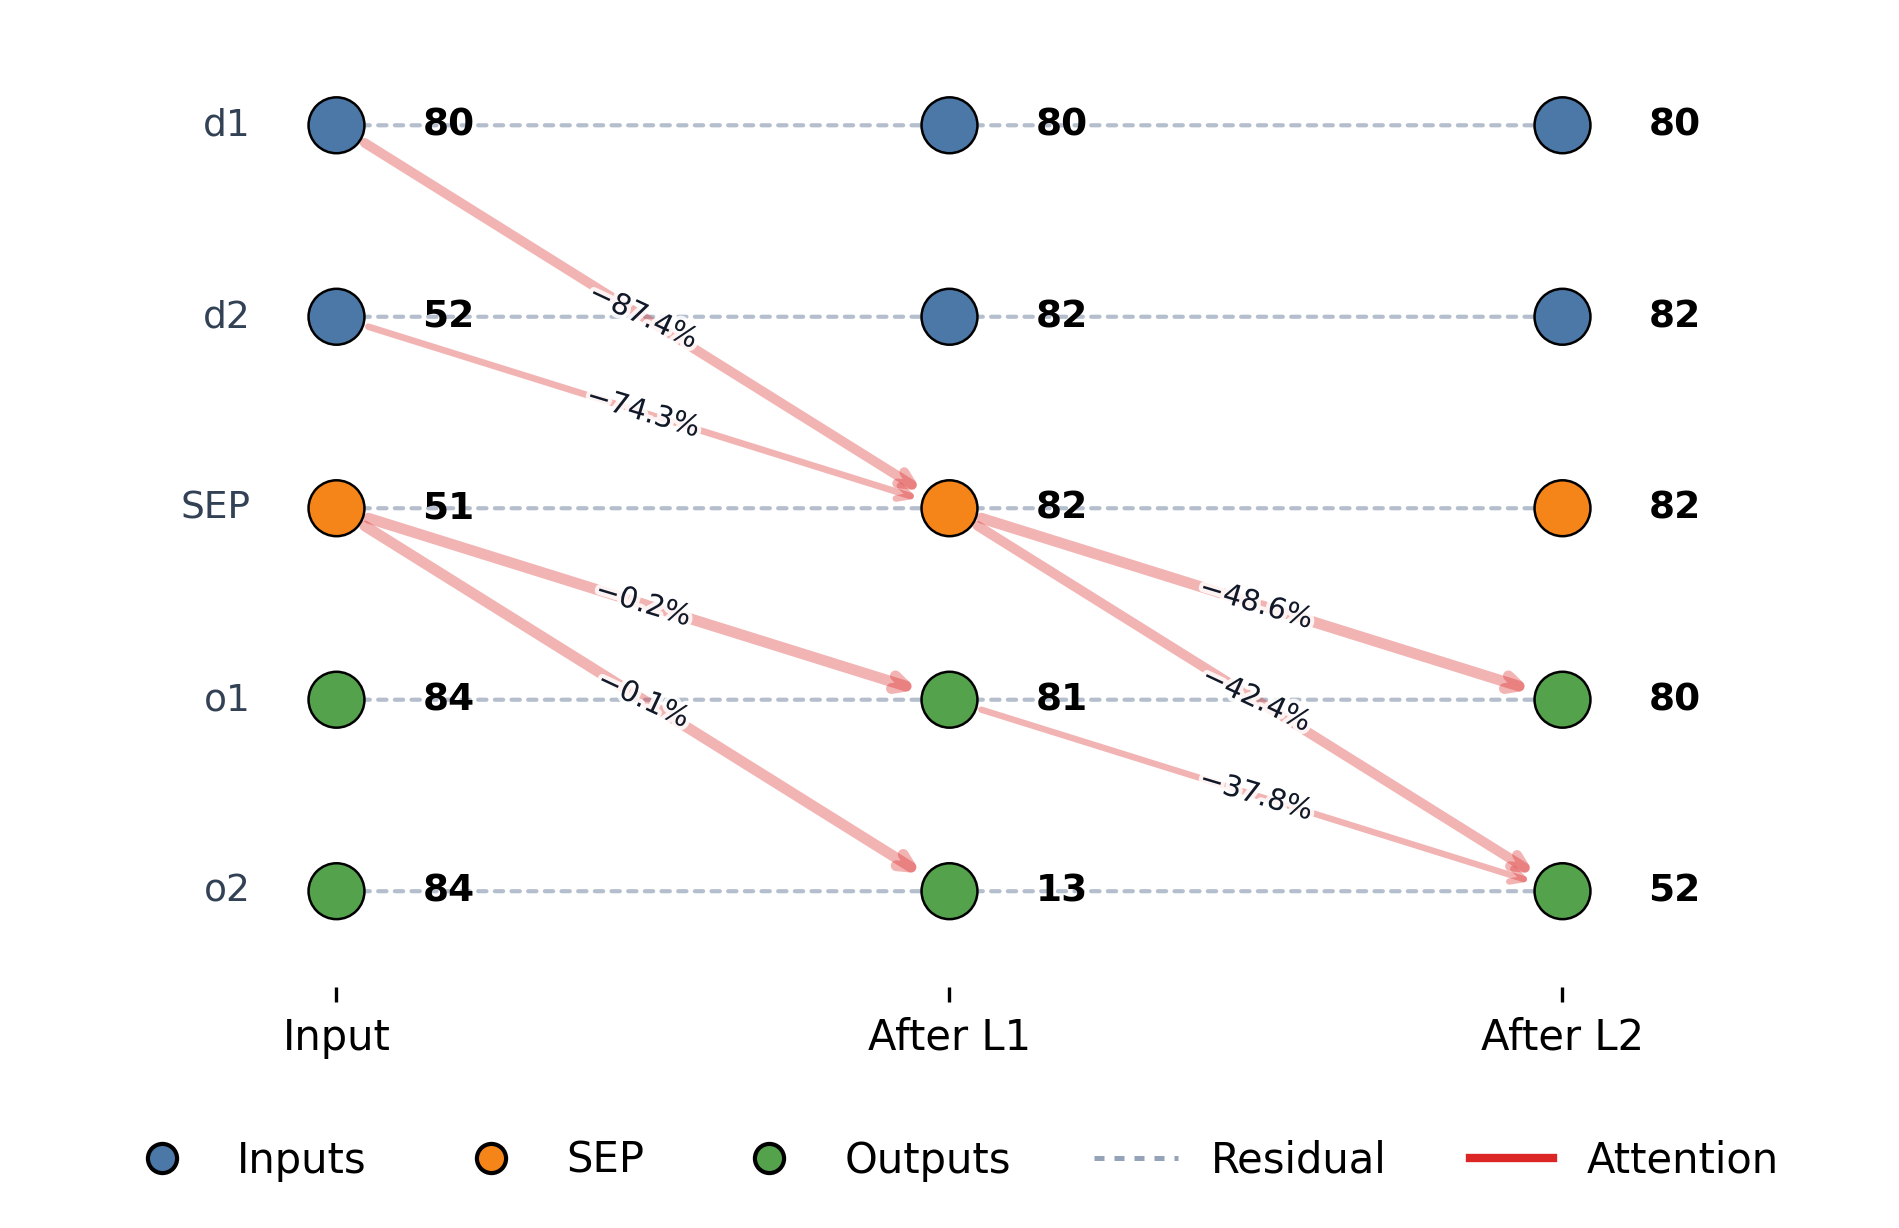

In [78]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as pe
from matplotlib.path import Path as MplPath  # NEW: inspect curve type

# Use a single validation example (sample_idx is defined earlier)
example = val_inputs[sample_idx].unsqueeze(0).to(DEV)

# Run and cache activations
_, cache = model.run_with_cache(example, return_type="logits")

# Collect attention patterns per layer -> shape [L, Q, K]
att = (
    torch.stack(
        [cache[f"blocks.{layer}.attn.hook_pattern"] for layer in range(model.cfg.n_layers)],
        dim=0,
    )
    .cpu()
    .numpy()
    .squeeze()
)

# prune arrows (these ones don't have any effect on the output)
if N_LAYER == 2:
    att[0][:2] = 0. * att[0][:2]
    att[1][:3] = 0. * att[1][:3]
elif N_LAYER == 3:
    ablate = {
        0: [(4, 2), (3, 2), (4, 3), (0, 0), (1, 0)],
        1: [(3, 2), (4, 3), (0, 0), (1, 0), (2, 1)],
        2: [(0, 0), (1, 0), (2, 0), (2, 1), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3)],
    }
    # Vectorized assignment using numpy indexing (robust for single/multiple pairs)
    for layer, pairs in ablate.items():
        if not pairs:
            continue
        arr = np.array(pairs, dtype=int)  # shape (n_pairs, 2)
        qs = arr[:, 0]
        ks = arr[:, 1]
        att[layer, qs, ks] = 0.0

# Collect residual stream (embed + post-resid after each layer)
resid_keys = ["hook_embed"] + [f"blocks.{l}.hook_resid_post" for l in range(model.cfg.n_layers)]
resid_values = torch.stack([cache[k] for k in resid_keys], dim=0)  # [L+1, 1, seq, d_model]

# Get W_U (compatibly)
W_U = getattr(model, "W_U", model.unembed.W_U)

# Logit lens: decode most likely token at each position after each layer
position_tokens = (resid_values @ W_U).squeeze(1).argmax(-1)  # [L+1, seq]

L, N, _ = att.shape

# Layout
x_positions = np.arange(L + 1)  # columns: input + after each layer
y_positions = np.arange(N)[::-1]  # top token index = 0

# Styling for publication (vector-safe fonts for PDF/SVG)
plt.rcParams.update({
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(6.8, 4.2), dpi=300)

# Node roles and colors
position_names = ["d1", "d2", "SEP", "o1", "o2"]
roles = ["input", "input", "sep", "output", "output"]
role_colors = {"input": "#4C78A8", "sep": "#F58518", "output": "#54A24B"}
node_colors = [role_colors[r] for r in roles]

# Draw nodes and labels (keep these on top of arrows)
for lx in range(L + 1):
    xs = np.full(N, lx)
    ax.scatter(xs, y_positions, s=180, c=node_colors,
               edgecolor="black", linewidth=0.6, zorder=4)
    # left: position label (only in first col); right: decoded token id (every col)
    for i, y in enumerate(y_positions):
        if lx == 0:
            ax.text(lx - 0.14, y, position_names[i], va="center", ha="right",
                    fontsize=9, color="#334155", zorder=5)
        ax.text(lx + 0.14, y, str(position_tokens[lx, i].item()),
                va="center", ha="left", fontsize=9, fontweight="bold",
                color="black", zorder=5)

# Residual stream (dotted straight arrows)
for lx in range(L):
    for y in y_positions:
        arrow = FancyArrowPatch((lx, y), (lx + 1, y),
                                arrowstyle="-", mutation_scale=8,
                                lw=1.0, linestyle=(0, (2, 2)), color="#94A3B8",
                                alpha=0.7, zorder=1, clip_on=False)
        ax.add_patch(arrow)

# --- Per-edge Δaccuracy placeholders ---
# Fill this dict with your measured changes in percentage points (pp).
# Key: (layer, query_idx, key_idx) where layer is 0-indexed.
# Example: delta_acc_pp[(0, 2, 0)] = -1.7  # ablating L0: q=SEP, k=d1 lowers acc by 1.7 pp
if N_LAYER == 2:
    delta_acc_pp = {
        # (l, q, k): value_in_pp,
        (0, 2, 0): -87.4, # sep --> d1
        (0, 2, 1): -74.3, # sep --> d2
        (0, 3, 2): -0.2, # o1 --> sep
        (0, 4, 2): -0.1, # o2 --> sep
        (1, 3, 2): -48.6, # o1 --> sep (L1)
        (1, 4, 2): -42.4, # o2 --> sep (L1)
        (1, 4, 3): -37.8, # o2 --> o1 (L1)
    }
elif N_LAYER == 3:
    delta_acc_pp = {
        (0, 2, 0): -1.3,
        (0, 2, 1): -49.6,
        (1, 2, 0): -49.6,
        (1, 4, 2): -49.5,
        (2, 3, 2): -49.5,
    }

def format_delta_pp(val):
    # Less obtrusive: short text, no "Δacc:" prefix
    if val is None:
        return "—"
    sign = "+" if val >= 0 else "−"
    return f"{sign}{abs(val):.1f}%"

# Attention edges (curved; width/alpha ~ weight)
threshold = 0.05  # ignore tiny weights
arrow_color = "#DC2626"   # red
arrow_alpha = 0.35        # translucent to avoid obscuring text

# Label controls
label_threshold = 0.05     # only label edges above this weight
show_placeholder = False   # set True to show "—" for missing entries
label_offset = 0.12        # distance of label from the edge midpoint

CURVE_STRENGTH = 0.0  # try 0.04–0.08; set 0.0 if you want perfectly straight

def edge_style(w):
    lw = 0.6 + 2.0 * np.sqrt(float(w))
    alpha = arrow_alpha
    return lw, alpha

def angle_in_display(ax, x0, y0, x1, y1):
    # Compute angle in screen space so rotation matches visual slope despite axis scales
    X0, Y0 = ax.transData.transform((x0, y0))
    X1, Y1 = ax.transData.transform((x1, y1))
    return np.degrees(np.arctan2(Y1 - Y0, X1 - X0))

for l in range(L):
    for q in range(N):
        for k in range(N):
            w = att[l, q, k]
            if w <= threshold:
                continue

            x0, y0 = l,      y_positions[k]
            x1, y1 = l + 1, y_positions[q]
            dy = y1 - y0

            # Curvature and style
            rad = np.sign(dy) * CURVE_STRENGTH * (min(abs(dy), 2) / 2.0)
            lw, alpha = edge_style(w)

            arrow = FancyArrowPatch(
                (x0, y0), (x1, y1),
                connectionstyle=f"arc3,rad={rad}",
                arrowstyle="->", mutation_scale=8,
                lw=lw, color=arrow_color, alpha=alpha,
                zorder=2, shrinkA=8, shrinkB=8,
                joinstyle="round", capstyle="round",
                clip_on=False,
            )
            ax.add_patch(arrow)

            # Check if a label should be drawn
            delta_val = delta_acc_pp.get((l, q, k))
            if (delta_val is None and not show_placeholder) or (w < label_threshold):
                continue
            
            label_text = format_delta_pp(delta_val)

            # --- NEW ROBUST LABEL PLACEMENT LOGIC ---

            # 1. Calculate the angle of the straight line between nodes in display space
            angle_deg = angle_in_display(ax, x0, y0, x1, y1) -8
            angle_rad = np.deg2rad(angle_deg)

            # 2. Calculate the simple midpoint of the straight line in data space
            mid_data = np.array([(x0 + x1) / 2.0, (y0 + y1) / 2.0])

            # 3. Calculate a perpendicular "nudge" vector in display space
            #    This vector points perpendicularly outwards from the line on the screen
            perp_vec_disp = np.array([-np.sin(angle_rad), np.cos(angle_rad)])
            
            # 4. Define how far to nudge the label in pixels.
            #    This is proportional to the curvature `rad`.
            #    This "magic number" controls the strength of the effect. Tune if needed.
            offset_strength_px = -400.0 
            pixel_offset = rad * offset_strength_px

            # 5. Apply the nudge in display space for visual correctness
            mid_disp = ax.transData.transform(mid_data)
            label_pos_disp = mid_disp + pixel_offset * perp_vec_disp
            
            # 6. Transform the final label position back to data space
            lx, ly = ax.transData.inverted().transform(label_pos_disp)

            # 7. Annotate at the final calculated position
            ann = ax.annotate(
                label_text,
                xy=(lx, ly),
                ha="center",
                va="center",
                fontsize=7,
                color="#111827",
                rotation=angle_deg, # Rotate to match the chord
                rotation_mode="anchor",
                zorder=4.2,
                clip_on=False,
            )
            ann.set_path_effects([pe.withStroke(linewidth=2.0, foreground="white", alpha=0.85)])
         
# Axes cosmetics
ax.set_xlim(-0.5, L + 0.5)
ax.set_ylim(-0.5, N - 0.5)
ax.set_xticks(x_positions)
ax.set_xticklabels(["Input"] + [f"After L{l+1}" for l in range(L)])
ax.set_yticks([])  # we draw our own labels
for spine in ax.spines.values():
    spine.set_visible(False)

# Legend (update attention color to red)
legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Inputs",
           markerfacecolor=role_colors["input"], markeredgecolor="black", markersize=7),
    Line2D([0], [0], marker="o", color="w", label="SEP",
           markerfacecolor=role_colors["sep"], markeredgecolor="black", markersize=7),
    Line2D([0], [0], marker="o", color="w", label="Outputs",
           markerfacecolor=role_colors["output"], markeredgecolor="black", markersize=7),
    Line2D([0], [0], linestyle=(0, (2, 2)), color="#94A3B8", lw=1.2, label="Residual"),
    Line2D([0], [0], color=arrow_color, lw=2, label="Attention"),
]
ax.legend(handles=legend_elements, frameon=False, ncol=5,
          loc="upper center", bbox_to_anchor=(0.5, -0.12))

plt.tight_layout()
plt.show()


## Attention Ablations

In [79]:
renorm_rows = False # whether to renormalize rows after ablation
ablate_in_l0 = [
                (4,3),
                (0,0),
                (1,0)
                ]
ablate_in_l1 = [
                (0,0),
                (1,0),
                (2,0),
                (2,1)
                ]

ablate_in_l2 = [(0,0),(1,0),(2,0), (2,1), (3,0),  (4,0), (4,1), (4,2), (4,3)]

# Try ablating multiple layer attention patterns at same time
def build_qk_mask(positions=None, queries=None, keys=None, seq_len=SEQ_LEN):
    """
    Create a boolean mask of shape (seq_len, seq_len) where True means "ablate this (q,k)".
    You can pass:
      - positions: list of (q, k) tuples
      - or queries: iterable of q, and keys: iterable of k (outer-product mask)
    """
    mask = torch.zeros(seq_len, seq_len, dtype=torch.bool)
    if positions is not None:
        for q, k in positions:
            mask[q, k] = True
    else:
        if queries is None:
            queries = range(seq_len)
        if keys is None:
            keys = range(seq_len)
        for q in queries:
            mask[q, keys] = True
    return mask

def make_pattern_hook(mask_2d: torch.Tensor, head_index=None, set_to=0.0, renorm=True, eps=1e-12):
    """
    Returns a fwd hook for the 'pattern' activation that:
      - sets masked entries to set_to (default 0.0)
      - optionally renormalizes rows so they sum to 1 again (per head, per batch, per query row)
    Args:
      mask_2d: Bool tensor [Q, K]
      head_index: int to affect a single head, or None to affect all heads
      set_to: value to write into masked entries (usually 0.0)
      renorm: whether to renormalize rows after masking
    """
    mask_2d = mask_2d.detach()

    def hook(pattern, hook):
        # pattern: [batch, n_heads, Q, K]
        B, H, Q, K = pattern.shape
        m4_all = mask_2d.to(pattern.device).view(1, 1, Q, K)  # broadcastable
        # Keep a copy for safe fallback in renorm
        pre = pattern.clone()
        print(f"\nLayer {hook.layer()} Ablation")
        print(f'BEFORE Ablation:\n{pattern[0, head_index, :, :].cpu().numpy()}')
        # print(f'Mask:\n{m4_all[0, 0, :, :].cpu().numpy()}')
        

        if head_index is None:
            pattern = torch.where(m4_all, torch.as_tensor(set_to, device=pattern.device), pattern)
        else:
            m3 = m4_all.squeeze(1)  # [1, Q, K]
            ph = pattern[:, head_index]  # [B, Q, K]
            ph = torch.where(m3, torch.as_tensor(set_to, device=pattern.device), ph)
            pattern[:, head_index] = ph

        if renorm:
            # Renormalize only rows whose query index has any masked key
            rows_to_fix = mask_2d.any(dim=-1)  # [Q]
            if rows_to_fix.any():
                rows_idx = rows_to_fix.nonzero(as_tuple=False).squeeze(-1)  # [Nr]
                heads = range(H) if head_index is None else [head_index]
                for h in heads:
                    # p: [B, Nr, K]
                    p = pattern[:, h, rows_idx, :]
                    s = p.sum(dim=-1, keepdim=True).clamp_min(eps)   # [B, Nr, 1]
                    pattern[:, h, rows_idx, :] = p / s

        print(f'AFTER Ablation:\n{pattern[0, head_index, :, :].cpu().numpy()}')
        return pattern

    return hook

# Example usage:
# Define what to ablate per layer:
# - As explicit (q,k) pairs
# - Or as queries/keys sets (outer-product)
layers_to_ablate = {
    0: build_qk_mask(positions=ablate_in_l0, seq_len=SEQ_LEN),
    1: build_qk_mask(positions=ablate_in_l1, seq_len=SEQ_LEN),
    # 2: build_qk_mask(positions=ablate_in_l2, seq_len=SEQ_LEN),
}

# Apply to a single head or all heads
head = None  # Set to None to affect all heads, or specify a head index (e.g., 0)

# Build hooks
fwd_hooks = []
for layer_idx, mask in layers_to_ablate.items():
    hook_name = utils.get_act_name("pattern", layer_idx)
    fwd_hooks.append((hook_name, make_pattern_hook(mask, head_index=head, set_to=0.0, renorm=renorm_rows)))

# Run with hooks and evaluate on last two positions
with torch.no_grad():
    logits_multi = model.run_with_hooks(val_inputs, return_type="logits", fwd_hooks=fwd_hooks)

output_logits_multi = logits_multi[:, LIST_LEN+1:]
ablated_output_predictions = output_logits_multi.argmax(dim=-1)
output_targets = val_targets[:, LIST_LEN+1:]

ablated_loss = loss_fn(output_logits_multi.reshape(-1, VOCAB), val_targets[:, LIST_LEN+1:].reshape(-1))
ablated_acc = (ablated_output_predictions == val_targets[:, LIST_LEN+1:]).float().mean()

print("\n--- Performance Metrics ---")
print(f"Multi-layer attention ablation -> Loss: {ablated_loss.item():.3f}, Acc: {ablated_acc.item():.3f}")

# Optional: inspect a sample
idx = sample_idx
print("Sample sequence:", val_inputs[idx].cpu().numpy())
print("Original:", original_predictions[idx].cpu().numpy())
print("Ablated: ", logits_multi.argmax(dim=-1)[idx].cpu().numpy())


Layer 0 Ablation
BEFORE Ablation:
[[[[1.00000 0.00000 0.00000 0.00000 0.00000]
   [1.00000 0.00000 0.00000 0.00000 0.00000]
   [0.75374 0.24626 0.00000 0.00000 0.00000]
   [0.00000 0.00000 1.00000 0.00000 0.00000]
   [0.00000 0.00000 0.99998 0.00002 0.00000]]]]
AFTER Ablation:
[[[[0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.75374 0.24626 0.00000 0.00000 0.00000]
   [0.00000 0.00000 1.00000 0.00000 0.00000]
   [0.00000 0.00000 0.99998 0.00000 0.00000]]]]

Layer 1 Ablation
BEFORE Ablation:
[[[[1.00000 0.00000 0.00000 0.00000 0.00000]
   [1.00000 0.00000 0.00000 0.00000 0.00000]
   [0.72548 0.27452 0.00000 0.00000 0.00000]
   [0.00000 0.00000 1.00000 0.00000 0.00000]
   [0.00000 0.00000 0.78624 0.21376 0.00000]]]]
AFTER Ablation:
[[[[0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 0.00000 0.00000 0.00000]
   [0.00000 0.00000 1.00000 0.00000 0.00000]
   [0.00000 0.00000 0.78624 0.2137

## PCA of W_U logits for two sets of positional projections


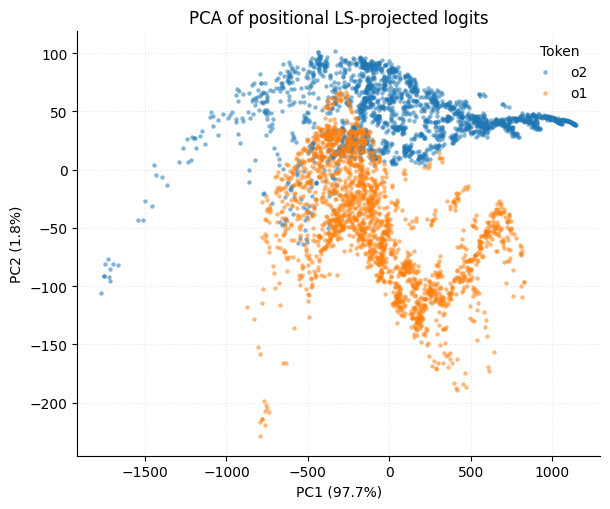

In [80]:
# Ensure we have a cache to use in the analysis
with torch.no_grad():
    logits, cache = model.run_with_cache(val_inputs, return_type="logits")

# Residuals: [batch, seq, d_model] or [seq, d_model]
resid = cache["resid_post", 1].detach().cpu().numpy()
if resid.ndim == 2:  # no batch
    resid = resid[None, ...]
if resid.shape[1] < 2:
    raise ValueError("Need sequence length >= 2 to compare -1 and -2.")

# Last and second-to-last token vectors
vecs_last = resid[:, -1, :]  # [B, d_model] -> o2 (last)
vecs_prev = resid[:, -2, :]  # [B, d_model] -> o1 (second-last)

# Positional matrix and projections
W_pos = model.W_pos.detach().cpu().numpy()
projs_last = (vecs_last @ W_pos.T)[:]
projs_prev = (vecs_prev @ W_pos.T)[:]

def plot_pca_two_sets(A: torch.Tensor, B: torch.Tensor, labels=("last", "prev")):
    with torch.no_grad():
        # Flatten leading dims -> [N, D]
        A2 = A.reshape(-1, A.shape[-1]).float().cpu()
        B2 = B.reshape(-1, B.shape[-1]).float().cpu()

        # Fit PCA on A∪B using SVD
        X_all = torch.cat([A2, B2], dim=0)                  # [N_total, D]
        mean = X_all.mean(0, keepdim=True)                  # [1, D]
        Xc = X_all - mean
        U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)
        comps = Vh[:2, :].T                                 # [D, 2]
        var_ratio = (S**2 / (S**2).sum())[:2]               # explained variance ratio

        # Project each set with the shared components
        A_pc = (A2 - mean) @ comps                          # [NA, 2]
        B_pc = (B2 - mean) @ comps                          # [NB, 2]

    cA, cB = "#1f77b4", "#ff7f0e"  # colorblind-friendly blue/orange
    fig, ax = plt.subplots(figsize=(6.2, 5.2))
    ax.scatter(A_pc[:, 0], A_pc[:, 1], s=10, color=cA, alpha=0.55, label=labels[0],
               linewidths=0, rasterized=True)
    ax.scatter(B_pc[:, 0], B_pc[:, 1], s=10, color=cB, alpha=0.55, label=labels[1],
               linewidths=0, rasterized=True)

    ax.set_xlabel(f"PC1 ({var_ratio[0].item():.1%})")
    ax.set_ylabel(f"PC2 ({var_ratio[1].item():.1%})")
    ax.legend(frameon=False, loc="best", title="Token")
    ax.set_title("PCA of positional LS-projected logits")
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.grid(True, linestyle=":", alpha=0.3)
    plt.tight_layout()
    plt.show()


with torch.no_grad():
    # Least-squares projection onto span(W_pos) before unembedding
    # projs_last/prev are (B, n_pos) = vec @ W_pos.T
    W_pos_t = model.W_pos.cpu()                         # [n_pos, d_model]
    G = W_pos_t @ W_pos_t.T                             # [n_pos, n_pos]
    G_inv = torch.linalg.pinv(G)                        # robust pseudo-inverse

    last_coeffs = torch.from_numpy(projs_last).to(W_pos_t.dtype) @ G_inv  # (B, n_pos)
    prev_coeffs = torch.from_numpy(projs_prev).to(W_pos_t.dtype) @ G_inv  # (B, n_pos)

    last_proj = last_coeffs @ W_pos_t                   # (B, d_model)
    prev_proj = prev_coeffs @ W_pos_t                   # (B, d_model)

    last_pos_projs_unembed = last_proj @ model.W_U.cpu()  # (B, vocab)
    prev_pos_projs_unembed = prev_proj @ model.W_U.cpu()  # (B, vocab)

# Clarified legend: A = o2 (last, -1), B = o1 (second-last, -2)
plot_pca_two_sets(
    last_pos_projs_unembed,
    prev_pos_projs_unembed,
    labels=("o2", "o1"),
)



The projections of the last and second-to-last token vectors onto the positional dimensions are linearly separable, revealing that this composition of positional encodings is key to separating the tokens back out.

This is clear from the PCA where there is a substantial gap between the two clusters on the PCA plot.

In [81]:
# --- SVM analysis ---
from sklearn.svm import SVC

# X: points, y: labels
X = np.vstack([projs_last, projs_prev])
y = np.hstack([np.ones(len(projs_last)), -np.ones(len(projs_prev))])

# hard-margin SVM via large C
clf = SVC(kernel="linear", C=1e6).fit(X, y)

separable = clf.score(X, y) > 0.99
print("Linearly separable:", separable)

if separable:
    w = clf.coef_[0]
    b = clf.intercept_[0]
    margin = 1.0 / np.linalg.norm(w)
    print("Margin:", margin)

Linearly separable: True
Margin: 2.430529309337948


In [82]:
# %% Demonstrate the two-slot algorithm on the validation set
model.eval()

def cos_batch(a, b):  # (B,d)
    return F.cosine_similarity(a, b, dim=-1)

wU = model.W_U  # (d_model, vocab)

write_cos, read_o1_cos, read_o2_cos = [], [], []
sep_pos, d1_pos, d2_pos, o1_pos, o2_pos = 2, 0, 1, 3, 4

contrib = {
    "o1_sep_to_d1": [],
    "o1_sep_to_d2": [],
    "o2_sep_to_d1": [],
    "o2_sep_to_d2": [],
    "o2_o1_to_d1": [],
    "o2_o1_to_d2": [],
}
acc_o2_orig, acc_o2_no_o1edge = 0, 0
tots = 0

with torch.no_grad():
    for inputs, targets in [[val_inputs, val_targets]]:
        inputs = inputs.to(DEV)

        logits, cache = model.run_with_cache(inputs, return_type="logits")

        # Residuals
        r0 = cache["hook_embed"] + cache["hook_pos_embed"]                 # (B,T,d)
        rL0 = cache["blocks.0.hook_resid_post"]                            # (B,T,d)
        rL1 = cache["blocks.1.hook_resid_post"]                            # (B,T,d)

        # Attention patterns
        pat0 = cache["blocks.0.attn.hook_pattern"][:, 0]                   # (B,Q,K)
        pat1 = cache["blocks.1.attn.hook_pattern"][:, 0]                   # (B,Q,K)

        # --- Layer 0: write both digits into SEP
        a1 = pat0[:, sep_pos, d1_pos].unsqueeze(-1)                        # (B,1)
        a2 = pat0[:, sep_pos, d2_pos].unsqueeze(-1)                        # (B,1)

        r_sep_pre  = r0[:, sep_pos, :]
        r_d1_pre   = r0[:, d1_pos, :]
        r_d2_pre   = r0[:, d2_pos, :]
        M_true     = rL0[:, sep_pos, :]                                    # r_SEP^(1)
        M_pred     = r_sep_pre + a1*r_d1_pre + a2*r_d2_pre                 # predicted by copy rule

        write_cos.append(cos_batch(M_true, M_pred).cpu())

        # --- Layer 1: read M into o1 and o2
        b1  = pat1[:, o1_pos, sep_pos].unsqueeze(-1)                       # o1<-SEP
        c1  = pat1[:, o2_pos, sep_pos].unsqueeze(-1)                       # o2<-SEP
        d1w = pat1[:, o2_pos, o1_pos].unsqueeze(-1)                        # o2<-o1

        r_o1_pre  = rL0[:, o1_pos, :]
        r_o2_pre  = rL0[:, o2_pos, :]
        r_o1_post = rL1[:, o1_pos, :]
        r_o2_post = rL1[:, o2_pos, :]

        r_o1_pred = r_o1_pre + b1*M_true
        r_o2_pred = r_o2_pre + c1*M_true + d1w*r_o1_pre

        read_o1_cos.append(cos_batch(r_o1_post, r_o1_pred).cpu())
        read_o2_cos.append(cos_batch(r_o2_post, r_o2_pred).cpu())

        # --- Direct logit attribution (per-source contributions)
        d1_tok = inputs[:, d1_pos]                                         # (B,)
        d2_tok = inputs[:, d2_pos]

        w_d1 = wU[:, d1_tok].T                                             # (B,d)
        w_d2 = wU[:, d2_tok].T

        def dot(v, w):  # (B,d)·(B,d)->(B,)
            return (v * w).sum(dim=-1)

        # o1 logits
        contrib["o1_sep_to_d1"].append(dot(b1*M_true, w_d1).cpu())
        contrib["o1_sep_to_d2"].append(dot(b1*M_true, w_d2).cpu())

        # o2 logits
        contrib["o2_sep_to_d1"].append(dot(c1*M_true,    w_d1).cpu())
        contrib["o2_sep_to_d2"].append(dot(c1*M_true,    w_d2).cpu())
        contrib["o2_o1_to_d1"].append(dot(d1w*r_o1_pre,  w_d1).cpu())
        contrib["o2_o1_to_d2"].append(dot(d1w*r_o1_pre,  w_d2).cpu())

        # --- Counterfactual: remove the o2<-o1 edge
        r_o2_no_o1 = r_o2_post - d1w*r_o1_pre
        logits_o2_cf = r_o2_no_o1 @ wU
        pred_o2_cf = logits_o2_cf.argmax(dim=-1)

        pred_o2 = logits[:, o2_pos, :].argmax(dim=-1)
        acc_o2_orig     += (pred_o2    == d2_tok).sum().item()
        acc_o2_no_o1edge += (pred_o2_cf == d2_tok).sum().item()
        tots += inputs.size(0)

# --- Summary
write_cos = torch.cat(write_cos)
read_o1_cos = torch.cat(read_o1_cos)
read_o2_cos = torch.cat(read_o2_cos)

print(f"L0 write recon cos  : mean {write_cos.mean():.4f}  median {write_cos.median():.4f}")
print(f"L1 read o1 recon cos: mean {read_o1_cos.mean():.4f}  median {read_o1_cos.median():.4f}")
print(f"L1 read o2 recon cos: mean {read_o2_cos.mean():.4f}  median {read_o2_cos.median():.4f}")

for k in contrib:
    contrib[k] = torch.cat(contrib[k])
print("\nDirect logit contributions (means):")
print(f"  o1: SEP→d1 {contrib['o1_sep_to_d1'].mean():.4f}, SEP→d2 {contrib['o1_sep_to_d2'].mean():.4f}")
print(f"  o2: SEP→d2 {contrib['o2_sep_to_d2'].mean():.4f}, SEP→d1 {contrib['o2_sep_to_d1'].mean():.4f}")
print(f"  o2: o1 →d1 {contrib['o2_o1_to_d1'].mean():.4f}  (expect <0),  o1→d2 {contrib['o2_o1_to_d2'].mean():.4f}")

frac_neg = (contrib["o2_o1_to_d1"] < 0).float().mean().item()
print(f"\nFrac(o2: o1→d1 contribution < 0): {frac_neg:.3f}")

print(f"\nSecond-digit accuracy:")
print(f"  original : {acc_o2_orig/tots:.4f}")
print(f"  no o2←o1 : {acc_o2_no_o1edge/tots:.4f}  (counterfactual by removing that path)")

L0 write recon cos  : mean 1.0000  median 1.0000
L1 read o1 recon cos: mean 1.0000  median 1.0000
L1 read o2 recon cos: mean 1.0000  median 1.0000

Direct logit contributions (means):
  o1: SEP→d1 28.7809, SEP→d2 -16.7887
  o2: SEP→d2 11.3083, SEP→d1 8.1326
  o2: o1 →d1 -1.6521  (expect <0),  o1→d2 38.5638

Frac(o2: o1→d1 contribution < 0): 0.424

Second-digit accuracy:
  original : 0.8540
  no o2←o1 : 0.0990  (counterfactual by removing that path)
